---
# Install the required packages

If needed install the following packages:

In [158]:
# !pip install tensorflow keras

---
# Imports

In [159]:
# Write your code here. Add as many boxes as you need.

---
# Laboratory Exercise - Run Mode (8 points)

## Introduction
In this laboratory assignment, the focus is on time series forecasting, specifically targeting the prediction of **R peak interval** for a patient. Your task involves employing deep learning methods to forecast the **required measurements**. To accomplish this you will be using a patient's ECG measurements from the MITDB database, which consists of the following values:

- R peak Interval (int: the time the R peak appeared)
- Beat Annotation (string: the beat type)
- Episode Annotation (string: the episode type)

**Note: You are required to perform this laboratory assignment on your local machine.**


# Read the data

You are required to load the given data from the `201_cleaned.ann` file (csv format). Load the data into a `pandas dataframe` and display the first 5 rows of the dataframe.

In [160]:
import pandas as pd
from pandas import DataFrame

# Write your code here. Add as many boxes as you need.
df = pd.read_csv("./201_cleaned.ann")

In [161]:
df

,R peak Interval,Beat Annotation,Episode Annotation
0,55,N,(AFIB
1,144,N,(AFIB
2,238,N,(AFIB
3,314,N,(AFIB
4,412,N,(AFIB
...,...,...,...
1999,225145,N,(N
2000,225206,a,(N
2001,225383,N,(N
2002,225410,x,(N


In [162]:
len(df["Episode Annotation"].unique())

5

In [163]:
df["Episode Annotation"].unique()

array(['(AFIB', '(NOD', '(N', '(T', '(SVTA'], dtype=object)

---
# EDA

## Explore the Beat Annotation Distribution

In [164]:
# Write your code here. Add as many boxes as you need.
len(df["Beat Annotation"].unique())

9

In [165]:
import matplotlib.pyplot as plt
import seaborn as sns
def grouped_corr(df: pd.DataFrame):
    qualitative_attributes = [col for col in df.columns if len(df[col].unique()) <= 10]
    quantitative_attributes = [col for col in df.columns if len(df[col].unique()) > 10]
    for cat in qualitative_attributes:
        for num in quantitative_attributes:
            print(cat+"--->"+num)
            print("####")
            print(df.groupby(cat)[num].mean())
            print("####")
            plt.figure(figsize=(8, 6))
            sns.boxplot(x=cat, y=num, data=df)
            plt.show()

In [166]:
def distributions(df:pd.DataFrame,columns:list[str]):
    for col in columns:
        plt.figure(figsize=(5,2))
        sns.countplot(x=col, data=df)
        plt.title(col)
        plt.show()

In [167]:
cat = list(df.select_dtypes(include=["object","category"]).columns)

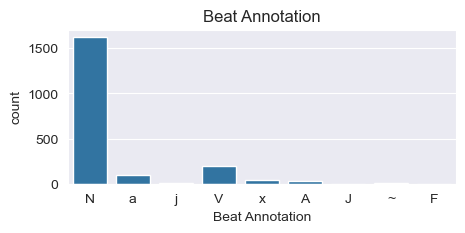

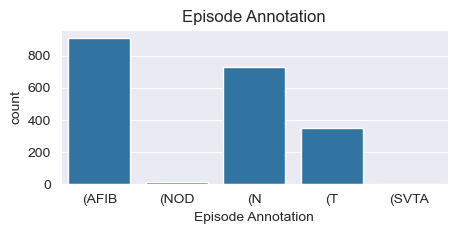

In [168]:
distributions(df,cat)

Beat Annotation--->R peak Interval
####
Beat Annotation
A    156327.833333
F    189502.000000
J     65832.000000
N    104781.849231
V    117970.828283
a    150070.288660
j    106648.000000
x    137510.189189
~    137541.500000
Name: R peak Interval, dtype: float64
####


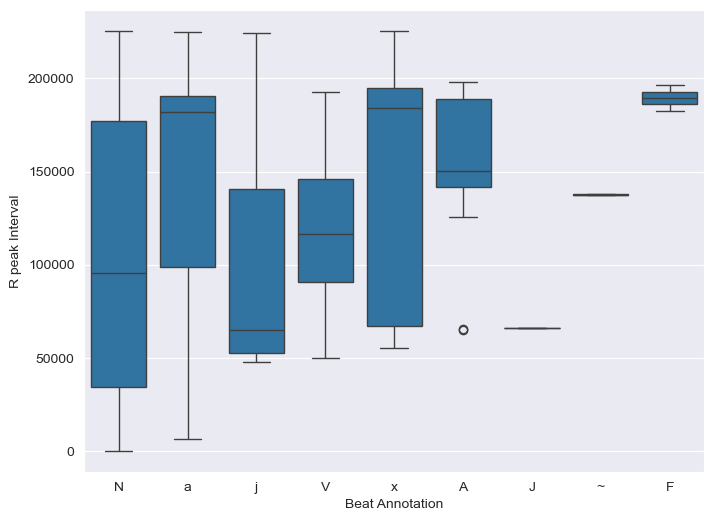

Episode Annotation--->R peak Interval
####
Episode Annotation
(AFIB     87058.721186
(N       134347.967123
(NOD     111259.000000
(SVTA    198206.333333
(T       117000.703170
Name: R peak Interval, dtype: float64
####


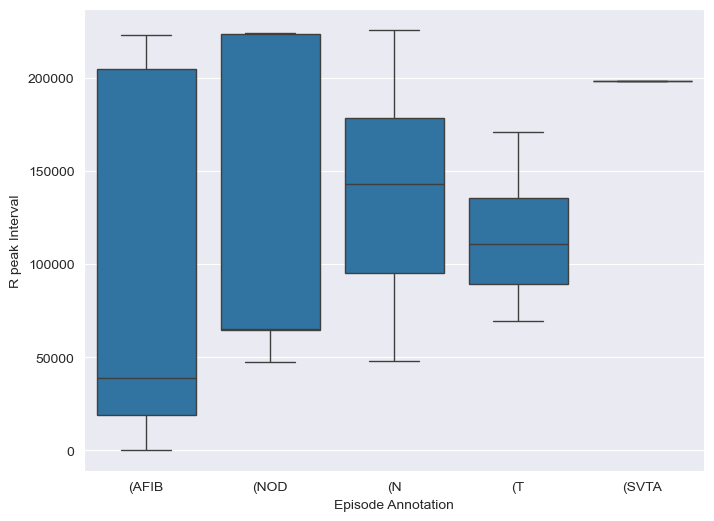

In [169]:
grouped_corr(df)

## Explore the Episode Annotation Distribution

In [170]:
# Write your code here. Add as many boxes as you need.

---
# Feature Engineering

## Re-Labeling the data (Beat Annotation)

Re-label the data into 3 beat types:
- Normal Beat (N)
- Ventricular Beat (V)
- Other Beats (Other)

In [171]:
# Write your code here. Add as many boxes as you need.
df["Beat Annotation"] = df["Beat Annotation"].apply( lambda x : x if x in ['N','V'] else 'Other') 

In [172]:
df["Beat Annotation"].unique()

array(['N', 'Other', 'V'], dtype=object)

Check that the mapping worked:

In [173]:
# Write your code here. Add as many boxes as you need.

## Re-Labeling the data (Episode Annotation)

Re-label the data into 3 beat types:
- Normal Episode: (N
- Atrial Fibrillation: (AFIB
- Other Episode: (Other

In [174]:
# Write your code here. Add as many boxes as you need.
df["Episode Annotation"] = df["Episode Annotation"].apply( lambda x : x if x in ["(N","(AFIB"] else 'Other') 


Check that the mapping worked:

In [175]:
# Write your code here. Add as many boxes as you need.
df["Episode Annotation"].unique()

array(['(AFIB', 'Other', '(N'], dtype=object)

## Create Lag Features (5 prev values) for R peak Interval measurement

Apply a lag for the R peak Interval, creating a set of features representing the historical patient data. To maintain dataset integrity, eliminate any resulting missing values at the beginning of the dataset.

Hint: Use `df['column_name'].shift(period)`. Check the documentation at https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.shift.html.

In [176]:
# Write your code here. Add as many boxes as you need.
def shift(df:pd.DataFrame,columns:list[str],n:int) -> pd.DataFrame:
    df_copy = df.copy(deep=True)
    lags = range(n, 0, -1)
    for lag in lags:
        for column in columns:
            df_copy[f"{column}_{lag}"] = df_copy[column].shift(lag)
    return df_copy

In [177]:
df = shift(df,["R peak Interval"],5)

In [178]:
df

,R peak Interval,Beat Annotation,Episode Annotation,R peak Interval_5,R peak Interval_4,R peak Interval_3,R peak Interval_2,R peak Interval_1
0,55,N,(AFIB,NaN,NaN,NaN,NaN,NaN
1,144,N,(AFIB,NaN,NaN,NaN,NaN,55.0
2,238,N,(AFIB,NaN,NaN,NaN,55.0,144.0
3,314,N,(AFIB,NaN,NaN,55.0,144.0,238.0
4,412,N,(AFIB,NaN,55.0,144.0,238.0,314.0
...,...,...,...,...,...,...,...,...
1999,225145,N,(N,224485.0,224545.0,224739.0,224764.0,224987.0
2000,225206,Other,(N,224545.0,224739.0,224764.0,224987.0,225145.0
2001,225383,N,(N,224739.0,224764.0,224987.0,225145.0,225206.0
2002,225410,Other,(N,224764.0,224987.0,225145.0,225206.0,225383.0


Check that the mapping worked:

In [179]:
# Write your code here. Add as many boxes as you need.

## Generate R-R interval features


For the past 5 R peak intervals ($R_{i}, i \in \{-1, -2, -3, -4, -5\}$), generate the 4 R-R intervals as features.

$RR_{i} = R_{i} - R_{i-1}$

In [180]:
# Write your code here. Add as many boxes as you need.
for i in range(1, 5):
    df[f'RR {i}'] = df[f'R peak Interval_{i}'] - df[f'R peak Interval_{i+1}']

Additionally, generate the current R-R Interval, which we will be using as a target.  

$RR_{curr} = (R_{0} - R_{-1})$

In [181]:
df['RR'] = df['R peak Interval'] - df['R peak Interval_1']

Check that the mapping worked:

In [182]:
df

,R peak Interval,Beat Annotation,Episode Annotation,R peak Interval_5,R peak Interval_4,R peak Interval_3,R peak Interval_2,R peak Interval_1,RR 1,RR 2,RR 3,RR 4,RR
0,55,N,(AFIB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,144,N,(AFIB,NaN,NaN,NaN,NaN,55.0,NaN,NaN,NaN,NaN,89.0
2,238,N,(AFIB,NaN,NaN,NaN,55.0,144.0,89.0,NaN,NaN,NaN,94.0
3,314,N,(AFIB,NaN,NaN,55.0,144.0,238.0,94.0,89.0,NaN,NaN,76.0
4,412,N,(AFIB,NaN,55.0,144.0,238.0,314.0,76.0,94.0,89.0,NaN,98.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1999,225145,N,(N,224485.0,224545.0,224739.0,224764.0,224987.0,223.0,25.0,194.0,60.0,158.0
2000,225206,Other,(N,224545.0,224739.0,224764.0,224987.0,225145.0,158.0,223.0,25.0,194.0,61.0
2001,225383,N,(N,224739.0,224764.0,224987.0,225145.0,225206.0,61.0,158.0,223.0,25.0,177.0
2002,225410,Other,(N,224764.0,224987.0,225145.0,225206.0,225383.0,177.0,61.0,158.0,223.0,27.0


In [183]:
# Write your code here. Add as many boxes as you need.


## Encode the categorical variables

In [193]:
from sklearn.preprocessing import OrdinalEncoder

# Write your code here. Add as many boxes as you need.
beat_enc = OrdinalEncoder()
episode_enc = OrdinalEncoder()

df['Beat Annotation'] = beat_enc.fit_transform(df[['Beat Annotation']])
df['Episode Annotation'] = episode_enc.fit_transform(df[['Episode Annotation']])

Check that the mapping worked:

In [194]:
# Write your code here. Add as many boxes as you need.
df.sample(10)

,R peak Interval,Beat Annotation,Episode Annotation,R peak Interval_5,R peak Interval_4,R peak Interval_3,R peak Interval_2,R peak Interval_1,RR 1,RR 2,RR 3,RR 4,RR
85,7147,0.0,0.0,6701.0,6802.0,6883.0,6961.0,7038.0,77.0,78.0,81.0,101.0,109.0
147,12282,0.0,0.0,11927.0,12022.0,12107.0,12159.0,12229.0,70.0,52.0,85.0,95.0,53.0
710,65998,1.0,1.0,65478.0,65647.0,65760.0,65832.0,65973.0,141.0,72.0,113.0,169.0,25.0
443,37654,0.0,0.0,37134.0,37256.0,37376.0,37490.0,37559.0,69.0,114.0,120.0,122.0,95.0
1477,172661,0.0,1.0,171921.0,172067.0,172227.0,172378.0,172520.0,142.0,151.0,160.0,146.0,141.0
1864,213232,0.0,0.0,212840.0,212911.0,212982.0,213047.0,213122.0,75.0,65.0,71.0,71.0,110.0
1324,151415,0.0,1.0,150669.0,150826.0,150969.0,151094.0,151266.0,172.0,125.0,143.0,157.0,149.0
750,71309,0.0,2.0,70577.0,70697.0,70863.0,71020.0,71140.0,120.0,157.0,166.0,120.0,169.0
1531,180592,0.0,1.0,179878.0,180016.0,180157.0,180301.0,180456.0,155.0,144.0,141.0,138.0,136.0
1858,212749,0.0,0.0,212262.0,212360.0,212441.0,212546.0,212639.0,93.0,105.0,81.0,98.0,110.0


---
# Model Training

## Remove unnecessary columns

For the purposes of training we will only be using the following columns as features:
- Beat Annotation
- Episode Annotation
- **All historical** 4 RR intervals

Moreover, the target column we will be forcasting is the ```current RR``` interval.

In [186]:
# Write your code here. Add as many boxes as you need.

## Dataset Splitting
Partition the dataset into training and testing sets with an 80:20 ratio.

**WARNING: DO NOT SHUFFLE THE DATASET.**

In [187]:
# Write your code here. Add as many boxes as you need.

## Neural Network (RNN / CRNN)

Create a deep (convolutional) recurrent neural network using:
- Minimum of 1 Convolutional Layer **(+2 points Optional)** and
- Minimum of 1 LSTM Layer

In [188]:
# Write your code here. Add as many boxes as you need.

**Reshape Data If Necessary**

In [189]:
# Write your code here. Add as many boxes as you need.

Compile and fit the model (Run only train 3 Epoch).

In [190]:
# Write your code here. Add as many boxes as you need.

---
# Model Evaluation

Use the trained model to make predictions for the test set.

In [191]:
# Write your code here. Add as many boxes as you need.

Assess the performance of the model by using different metrics provided by the `scikit-learn` library.

In [192]:
# Write your code here. Add as many boxes as you need.